# <p style="font-size: 36px;background-color:#058fd9; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Predicting Astronaut Psychological Resilience for Long Duration Space Missions </p>
## Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#preprocessing)
4. [Feature Engineering](#feature-engineering)
5. [Model Training, 3 hyperparameters for XGBoost](#model-training)
6. [Feature Importance with SHAP](#interpretability)

# Goal

The Goal is to develop a machine learning model to predict whether an astronaut will maintain psychological resilience (satisfied mental state) during long-duration space missions (e.g., Mars missions or extended stays on a space station) based on mission-related data and psychological data.

Target Variable: Psychological_Resilience (1 = "Resilient/Satisfied," 0 = "Not Resilient/Not Satisfied").

Missiondata: Contains attributes about the astronaut, their role, and mission conditions (e.g., mission duration, spacecraft type, crew size, workload intensity, or habitat conditions).

Statedata: Aggregated survey responses capturing astronauts’ psychological states, stress levels, mood, and coping mechanisms during or after simulated missions (e.g., from NASA’s Human Exploration Research Analog or similar studies).


# 🧪 Space Mission Behavioral Dataset (Simulated with Faker)

Welcome to the **Space Mission Behavioral Dataset** 

This is a simulated dataset created using the Python `Faker` library, with a touch of imagination and correlation-driven feature engineering. The aim is to explore how astronauts behave and adapt psychologically during space missions.

This is a first attempt — feel free to build on it, analyze patterns, and improve the model.

---

## 📦 Dataset Overview

This dataset includes two primary components:

### 🚀 Mission Data

Details related to the space mission and astronaut role.

| Feature | Description |
|--------|-------------|
| `Astronauts_Gender` | Gender of astronaut: `Male` or `Female` |
| `Flight_Status` | Flight experience: `First Mission`, `Experienced`, or `Veteran` |
| `Age_At_Launch` | Age at launch (in years) |
| `Mission_Purpose` | Main goal: `Science` or `Exploration` |
| `Orbit_Distance_km` | Distance traveled in orbit (in kilometers) |
| `Vehicle_Model` | Spacecraft: `Dragon`, `Orion`, or `Starliner` |
| `Launch_Hold_Minutes` | Delay before launch (in minutes) |
| `Reentry_Delay_Minutes` | Delay upon reentry (in minutes) |

---

### 🧠 State Data

Psychological and behavioral status during the mission.

| Feature | Description |
|--------|-------------|
| `Astronaut` | Unique identifier |
| `Overall_Experience` | Satisfaction: `1` (Satisfied), `0` (Not Satisfied) |
| `Stress_Level` | `Low`, `Medium`, or `High` |
| `Happiness` | Scale from `0` to `9` (note: `10` never occurs) |
| `Mood_Score` | `Negative`, `Neutral`, or `Positive` |
| `Adaptability` | Coping style: `Problem Focus` or `Emotion Focus` |
| `Sleep_Quality` | % of N2 sleep (Deeper sleep stage) per total sleep |
| `Suspect_Behavior` | Unusual behavior detected: `1` (Yes) or `0` (No) |
| `Workload_Perception` | Perception: `Easy`, `Possible`, `Difficult`, `Impossible` |
| `Time_Perception` | Perception of time: `Slow`, `Normal`, or `Fast` |
| `Food` | Food satisfaction: `Bad`, `Neutral`, or `Good` |
| `Sociability` | Time spent interacting with others (in hours) |
| `Communication_with_Earth_mins` | Weekly communication time with Earth (in minutes) |
| `Pet_the_Robot_Cat` | Number of times the astronaut interacted with a robot cat (haptic support for psychological needs) |

---

## 💡 Ideas to Explore

- Feature correlations: Does *Orbit Distance* relate to *Stress Level*?
- Time series evolution: Simulate daily mood or sleep tracking.
- Build a recommendation model: Improve mission planning based on satisfaction scores.
- Build a dashboard: Show astronaut wellbeing indicators over time.

---

## Note

This dataset is **synthetic**, but grounded in real psychological theory and mission design practices. Have fun exploring, modeling, and imagining future missions!

---

> *“The important achievement of Apollo was demonstrating that humanity is not forever chained to this planet.”* — Neil Armstrong


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
mission_train = pd.read_csv('C:\\Users\\joewi\\Downloads\\train\\Missiondata_train.csv')
state_train = pd.read_csv('C:\\Users\\joewi\\Downloads\\train\\Statedata_train.csv')
mission_test = pd.read_csv('C:\\Users\\joewi\\Downloads\\test\\Missiondata_test.csv')
state_test = pd.read_csv('C:\\Users\\joewi\\Downloads\\test\\Statedata_test.csv')
y_test = pd.read_csv('C:\\Users\\joewi\\Downloads\\submission.csv')

In [3]:
train_data = mission_train.merge(state_train, on='Astronaut_ID', how='inner')
test_data = mission_test.merge(state_test, on='Astronaut_ID', how='inner')

In [4]:
train_data.head()

,Astronaut_ID,Gender,Flight_Status,Age_At_Launch,Mission_Purpose,Orbit_Distance_km,Vehicle_Model,Launch_Hold_Minutes,Reentry_Delay_Minutes,Overall_Experience,...,Mood_Score,Adaptability,Sleep_Quality,Suspect_Behavior,Workload Perception,Time_Perception,Food,Sociability,Communication_with_Earth_mins,Pet_the_Robot_Cat
0,98800001,Male,First Mission,39,Science,469,Dragon,15.22,1.68,1,...,Positive,Problem Focus,6.77,1,Impossible,Slow,Bad,270.956717,0.11,0
1,98800002,Female,Veteran,51,Science,500,Orion,9.64,0.00,1,...,Neutral,Emotion Focus,4.65,0,Possible,Slow,Neutral,248.884353,0.73,0
2,98800003,Male,First Mission,39,Science,511,Orion,8.42,2.27,1,...,Positive,Problem Focus,2.10,0,Impossible,Normal,Bad,312.579875,7.46,0
3,98800004,Male,Experienced,42,Science,762,Starliner,13.43,0.35,1,...,Positive,Emotion Focus,4.90,0,Possible,Fast,Bad,261.460772,9.59,1
4,98800005,Male,Experienced,49,Science,765,Dragon,18.92,1.05,0,...,Negative,Emotion Focus,6.27,1,Impossible,Normal,Good,240.582759,0.42,0


In [5]:
train_data.shape

(94379, 22)

Data on 94,379 astronauts across 22 variables are available for exploration

# Exploratory Data Analysis (EDA):

In [6]:
print("Dataset Shape:", train_data.shape)

print("\nDataset Info:")
print(train_data.info())

print("\nMissing Values:")
print(train_data.isnull().sum())

Dataset Shape: (94379, 22)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Astronaut_ID                   94379 non-null  int64  
 1   Gender                         94379 non-null  object 
 2   Flight_Status                  94379 non-null  object 
 3   Age_At_Launch                  94379 non-null  int64  
 4   Mission_Purpose                94379 non-null  object 
 5   Orbit_Distance_km              94379 non-null  int64  
 6   Vehicle_Model                  94379 non-null  object 
 7   Launch_Hold_Minutes            94379 non-null  float64
 8   Reentry_Delay_Minutes          94379 non-null  float64
 9   Overall_Experience             94379 non-null  int64  
 10  Stress_Level                   94379 non-null  float64
 11  Happiness                      94379 non-null  int64  
 12  Mood

In [7]:
numeric_columns = [
    'Astronaut_ID', 'Age_At_Launch', 'Orbit_Distance_km', 'Launch_Hold_Minutes',
    'Reentry_Delay_Minutes', 'Sleep_Quality', 'Suspect_Behavior',
    'Sociability', 'Communication_with_Earth_mins', 'Pet_the_Robot_Cat', 'Happiness'
]
categorical_columns = [
    'Gender', 'Flight_Status', 'Mission_Purpose', 'Vehicle_Model',
    'Stress_Level', 'Mood_Score', 'Adaptability', 'Workload Perception',
    'Time_Perception', 'Food'
]
target_column = 'Overall_Experience'

for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(train_data[col].value_counts(dropna=False))


Unique values in Gender:
Gender
Female    47247
Male      47132
Name: count, dtype: int64

Unique values in Flight_Status:
Flight_Status
Experienced      47219
First Mission    28278
Veteran          18882
Name: count, dtype: int64

Unique values in Mission_Purpose:
Mission_Purpose
Science        56558
Exploration    37821
Name: count, dtype: int64

Unique values in Vehicle_Model:
Vehicle_Model
Orion        31660
Starliner    31423
Dragon       31296
Name: count, dtype: int64

Unique values in Stress_Level:
Stress_Level
11.929820    2
14.663083    2
17.741463    2
16.406965    2
15.237478    2
            ..
15.814495    1
14.426880    1
18.575545    1
16.501368    1
16.727504    1
Name: count, Length: 94372, dtype: int64

Unique values in Mood_Score:
Mood_Score
Neutral     47095
Positive    28463
Negative    18821
Name: count, dtype: int64

Unique values in Adaptability:
Adaptability
Problem Focus    47278
Emotion Focus    47101
Name: count, dtype: int64

Unique values in Workload Pe

In [8]:
for df in [train_data, test_data]:
	if 'Astronaut_ID' in df.columns:
		df.drop('Astronaut_ID', axis=1, inplace=True)

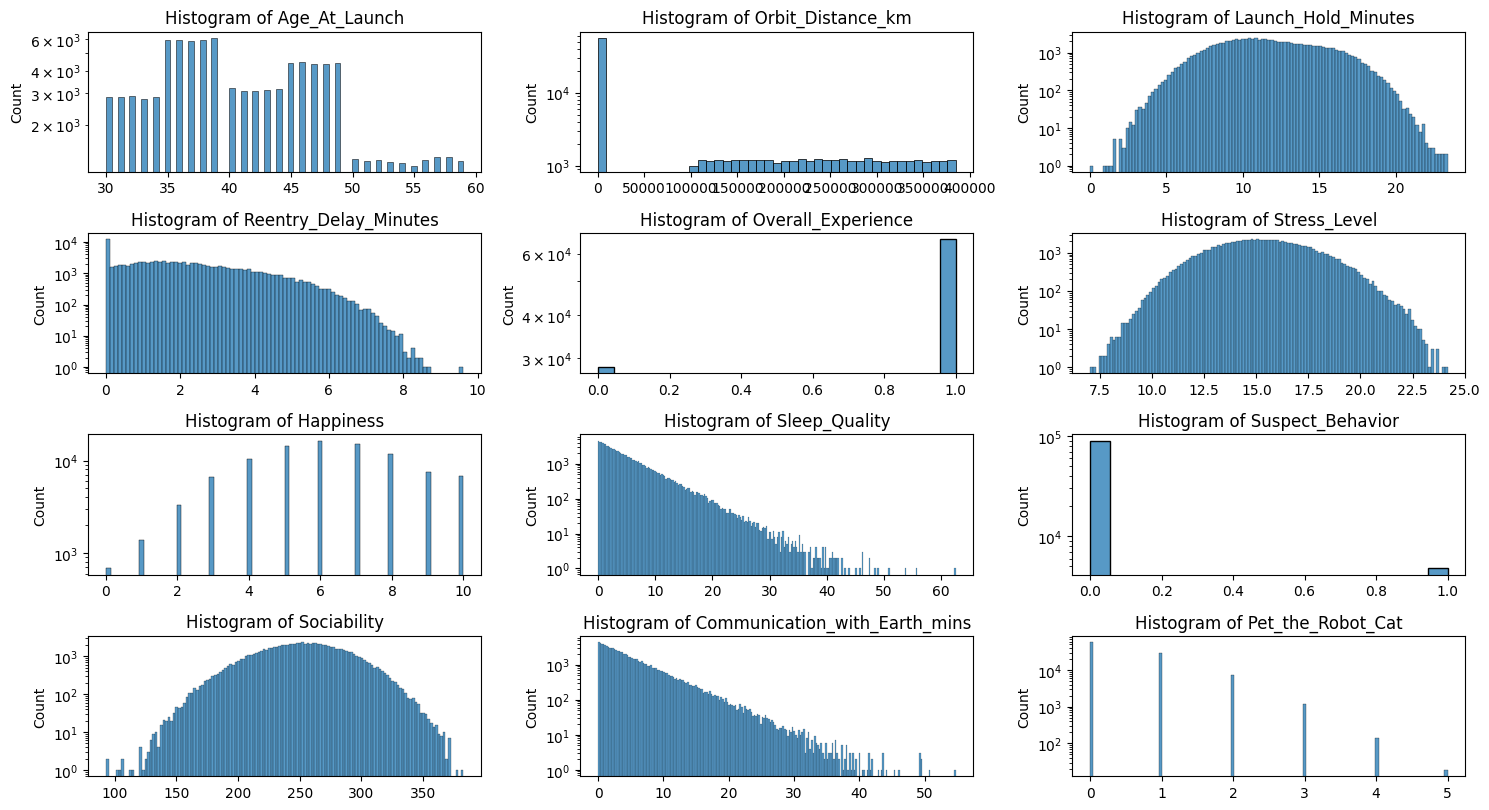

In [9]:
import math
numeric_cols = train_data.select_dtypes(include='number').columns
n = len(numeric_cols)
rows = math.ceil(n / 2)
fig, ax = plt.subplots(rows, 3, figsize=(15, 2 * rows))
ax = ax.flatten()

for i, feat in enumerate(numeric_cols):
    sns.histplot(train_data[feat].values, ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_title(f"Histogram of {feat}")

# Hide unused axes
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

Age_At_Launch
Skew : 0.45


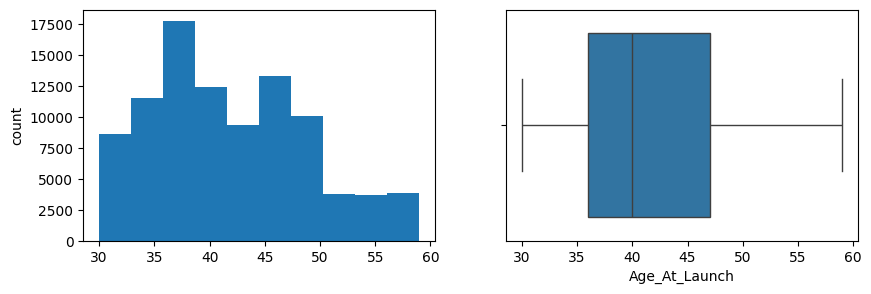

Orbit_Distance_km
Skew : 0.85


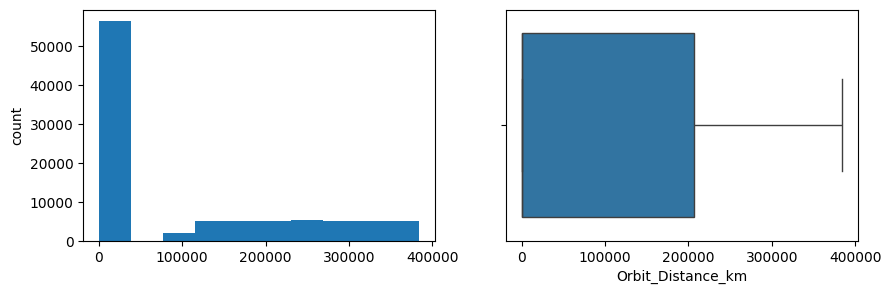

Launch_Hold_Minutes
Skew : 0.17


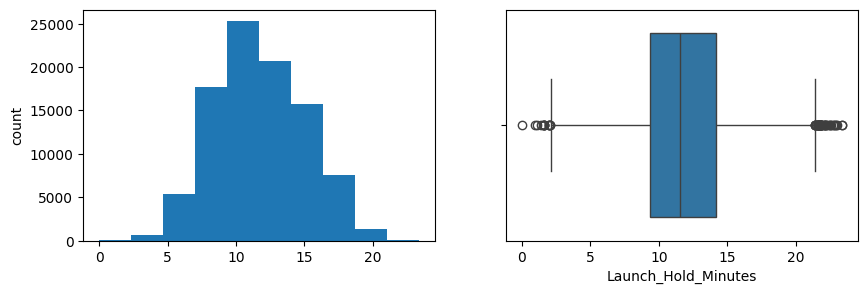

Reentry_Delay_Minutes
Skew : 0.61


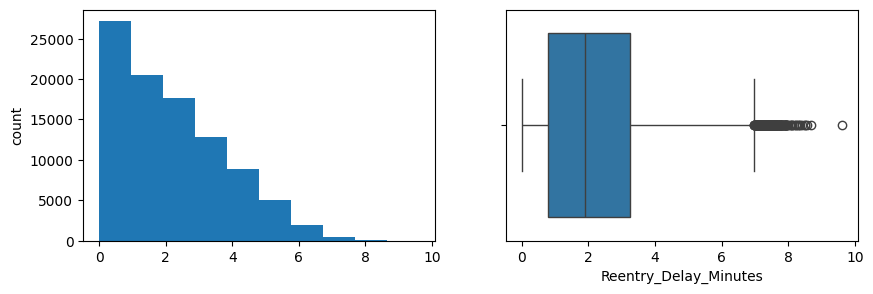

Overall_Experience
Skew : -0.87


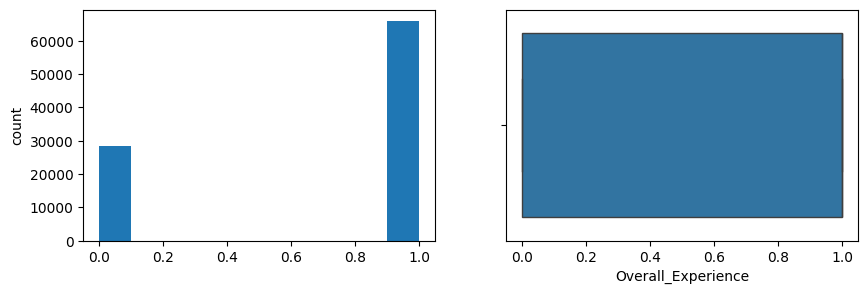

Stress_Level
Skew : 0.12


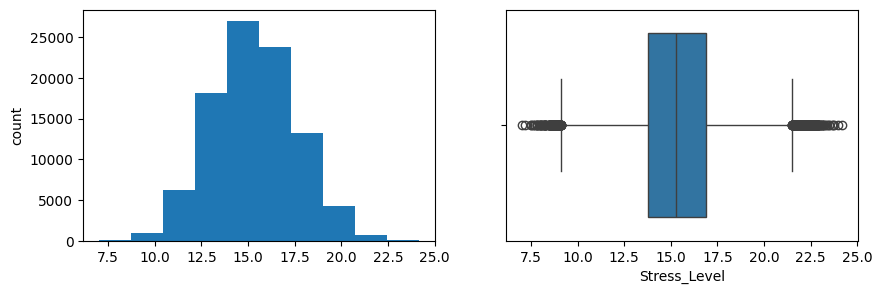

Happiness
Skew : -0.19


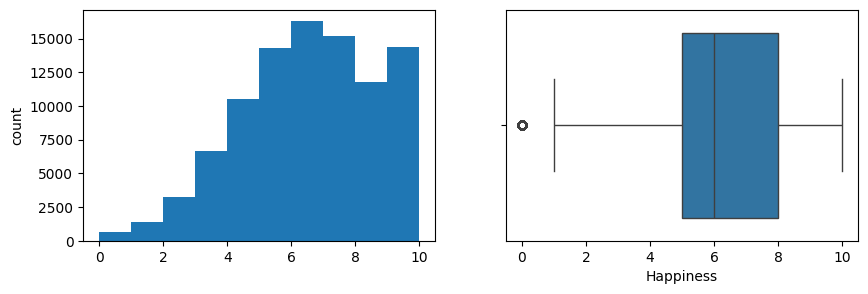

Sleep_Quality
Skew : 2.01


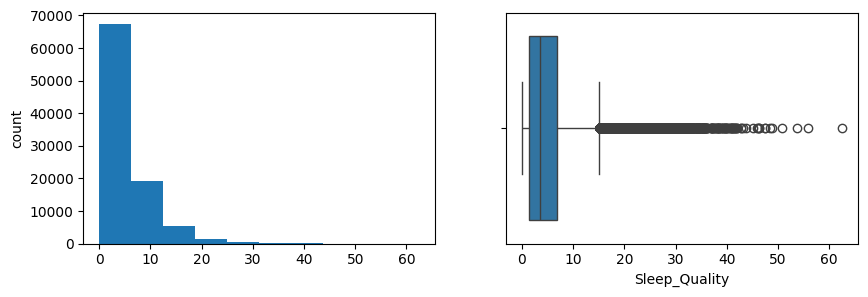

Suspect_Behavior
Skew : 4.1


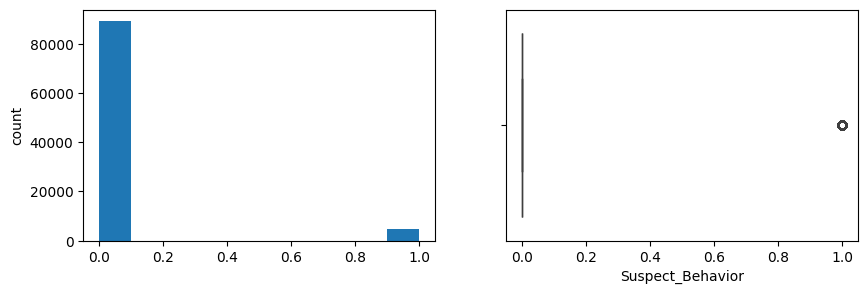

Sociability
Skew : -0.09


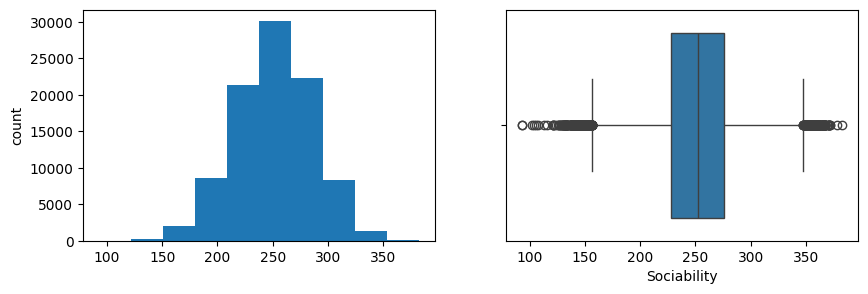

Communication_with_Earth_mins
Skew : 1.96


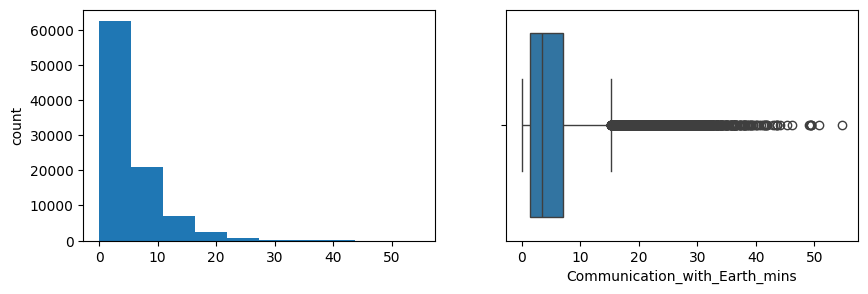

Pet_the_Robot_Cat
Skew : 1.41


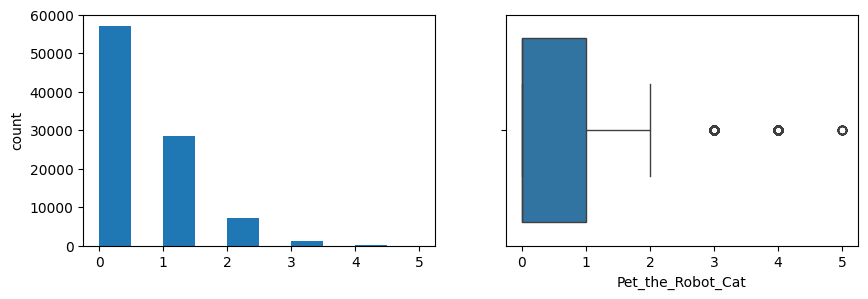

In [10]:
result = train_data.select_dtypes(include = 'number')

cont_cols = list(result)

for col in cont_cols:

    print(col)
    
    print('Skew :',round(train_data[col].skew(),2))
    
    plt.figure(figsize = (10, 3))
    
    plt.subplot(1, 2, 1)
    
    train_data[col].hist(bins = 10, grid = False)
    
    plt.ylabel('count')
    
    plt.subplot(1, 2, 2)
    
    sns.boxplot(x = train_data[col])
    
    plt.show()

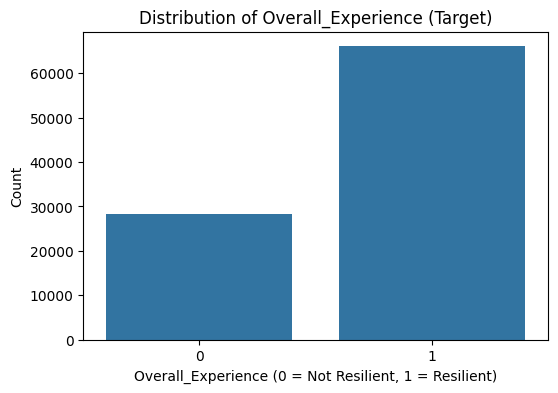

In [11]:
# Plot the distribution of the target column (0 or 1)
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column, data=train_data) 
plt.title('Distribution of Overall_Experience (Target)')
plt.xlabel('Overall_Experience (0 = Not Resilient, 1 = Resilient)')
plt.ylabel('Count')
plt.show()   

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'Age_At_Launch'),
  Text(1.5, 0, 'Orbit_Distance_km'),
  Text(2.5, 0, 'Launch_Hold_Minutes'),
  Text(3.5, 0, 'Reentry_Delay_Minutes'),
  Text(4.5, 0, 'Overall_Experience'),
  Text(5.5, 0, 'Stress_Level'),
  Text(6.5, 0, 'Happiness'),
  Text(7.5, 0, 'Sleep_Quality'),
  Text(8.5, 0, 'Suspect_Behavior'),
  Text(9.5, 0, 'Sociability'),
  Text(10.5, 0, 'Communication_with_Earth_mins'),
  Text(11.5, 0, 'Pet_the_Robot_Cat')])

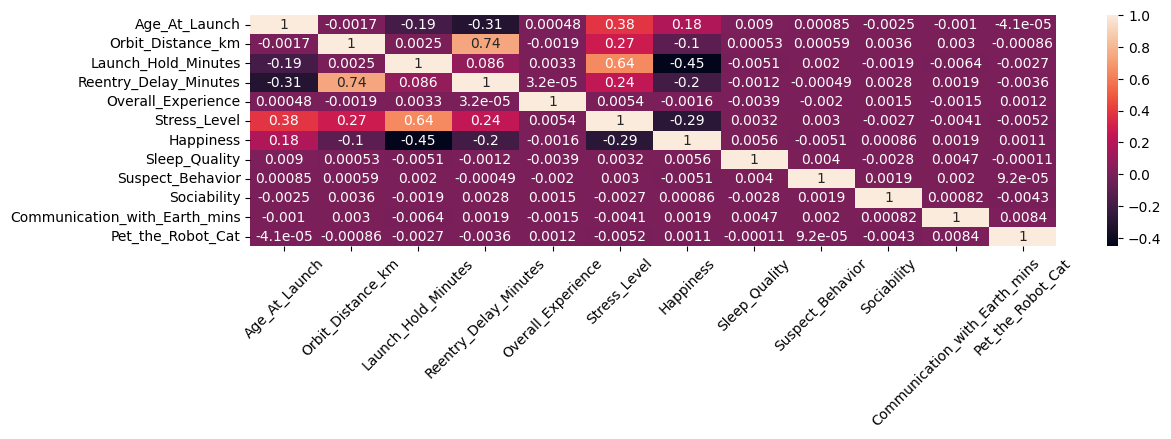

In [12]:
fig = plt.figure(figsize=(13, 3))
corr_matrix = train_data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=45)

# Data Preprocessing:
Handle missing values (e.g., impute with median/mean or use ML-based imputation) = None here

Encode categorical variables (e.g., spacecraft type, role) using one-hot or label encoding.

Normalize numerical features (e.g., mission duration, stress scores).

Perform feature engineering, such as creating interaction terms (e.g., stress level × sleep quality) or deriving new features like crew cohesion scores.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Only process columns that exist in train_data
existing_numeric = [col for col in numeric_columns if col in train_data.columns]
existing_cats = [col for col in categorical_columns if col in train_data.columns]

# Encode target if needed
if train_data[target_column].dtype == 'object':
    le = LabelEncoder()
    train_data[target_column] = le.fit_transform(train_data[target_column])
    print(f"Encoded classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Impute numeric columns
if existing_numeric:
    numeric_imputer = SimpleImputer(strategy='median')
    train_data[existing_numeric] = numeric_imputer.fit_transform(train_data[existing_numeric])

# Impute categorical columns
if existing_cats:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    train_data[existing_cats] = categorical_imputer.fit_transform(train_data[existing_cats])

# Outlier clipping for numeric columns (keeps same amount of data)
for col in existing_numeric:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_data[col] = train_data[col].clip(lower=lower_bound, upper=upper_bound)


In [14]:
X = train_data.drop(columns=['Overall_Experience'])
y = train_data['Overall_Experience']
X_test = test_data.copy()
test_ids = test_data['Astronaut_ID'] if 'Astronaut_ID' in test_data.columns else test_data.index


class_dist = y.value_counts(normalize=True)
print("Class distribution:", class_dist)
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.4f}")


Class distribution: Overall_Experience
1    0.699796
0    0.300204
Name: proportion, dtype: float64
scale_pos_weight: 0.4290


In [15]:
X = train_data.drop(columns=[target_column])
y = train_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Initiate scaler

In [16]:
from sklearn.preprocessing import StandardScaler

numeric_features = [
	'Age_At_Launch', 'Orbit_Distance_km', 'Launch_Hold_Minutes',
	'Reentry_Delay_Minutes', 'Sleep_Quality', 'Suspect_Behavior',
	'Sociability', 'Communication_with_Earth_mins', 'Pet_the_Robot_Cat', 'Happiness'
]

sc = StandardScaler()

X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

X_train_transformed[numeric_features] = sc.fit_transform(X_train[numeric_features])
X_test_transformed[numeric_features] = sc.transform(X_test[numeric_features])

X_train_transformed.describe().T


,count,mean,std,min,25%,50%,75%,max
Age_At_Launch,75503.0,-2.407280e-16,1.000007,-1.622673,-0.793736,-0.241111,0.725983,2.383858
Orbit_Distance_km,75503.0,-4.517178e-17,1.000007,-0.751680,-0.749766,-0.747805,0.849281,2.224001
Launch_Hold_Minutes,75503.0,5.783870e-16,1.000007,-2.952111,-0.739135,-0.074935,0.733122,2.949160
Reentry_Delay_Minutes,75503.0,-2.006380e-16,1.000007,-1.294432,-0.817139,-0.146512,0.669116,2.922665
Happiness,75503.0,-1.253517e-16,1.000007,-2.529732,-0.498195,-0.046743,0.856162,1.759067
Sleep_Quality,75503.0,-1.831810e-16,1.000007,-1.132549,-0.791129,-0.304067,0.519640,2.485794
Suspect_Behavior,75503.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sociability,75503.0,-2.352697e-18,1.000007,-2.720460,-0.672750,0.015205,0.690403,2.730874
Communication_with_Earth_mins,75503.0,-1.549486e-16,1.000007,-1.133084,-0.791009,-0.309745,0.515953,2.474037
Pet_the_Robot_Cat,75503.0,-2.164481e-18,1.000007,-0.728467,-0.728467,-0.728467,0.749272,2.965881


### Feature Engineering

In [26]:
mood_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
adapt_map = {'Problem Focus': 1, 'Emotion Focus': 0}
workload_map = {'Easy': 1, 'Possible': 2, 'Difficult': 3, 'Impossible': 4}
stress_map = {'Low': 1, 'Medium': 2, 'High': 3}

for df in [X_train, test_data]:
    if 'Mood_Score' in df.columns:
        df['Mood_Score_Enc'] = df['Mood_Score'].map(mood_map)
    if 'Adaptability' in df.columns:
        df['Adaptability_Enc'] = df['Adaptability'].map(adapt_map)
    if 'Workload Perception' in df.columns:
        df['Workload_Num'] = df['Workload Perception'].map(workload_map)
    if 'Stress_Level' in df.columns:
        df['Stress_Num'] = df['Stress_Level'].map(stress_map)


orbit_threshold = train_data['Orbit_Distance_km'].quantile(0.95)
for df in [X_train, test_data]:
    if 'Orbit_Distance_km' in df.columns:
        df['High_Orbit'] = (df['Orbit_Distance_km'] > orbit_threshold).astype(int)


sleep_threshold = train_data['Sleep_Quality'].quantile(0.25)
for df in [X_train, test_data]:
    if 'Sleep_Quality' in df.columns:
        df['Sleep_Deficit'] = (df['Sleep_Quality'] < sleep_threshold).astype(int)


social_threshold = train_data['Sociability'].quantile(0.25)
for df in [X_train, test_data]:
    if 'Sociability' in df.columns:
        df['Social_Isolation'] = (df['Sociability'] < social_threshold).astype(int)

for df in [X_train, test_data]:
    
    if 'Happiness' in df.columns and 'Sleep_Quality' in df.columns:
        df['Happiness_x_Sleep'] = df['Happiness'] * df['Sleep_Quality']
    
    if 'Sociability' in df.columns and 'Communication_with_Earth_mins' in df.columns:
        df['Social_Comm_Sum'] = df['Sociability'] + df['Communication_with_Earth_mins']
    
    if 'Workload_Num' in df.columns and 'Stress_Num' in df.columns:
        df['Workload_Stress_Ratio'] = df['Workload_Num'] / (df['Stress_Num'].replace(0, np.nan))
    
    if 'Sleep_Quality' in df.columns and 'Workload_Num' in df.columns:
        df['Sleep_to_Work'] = df['Sleep_Quality'] / (df['Workload_Num'].replace(0, np.nan))


for df in [X_train, test_data]:
    for col in ['Workload_Stress_Ratio', 'Sleep_to_Work']:
        if col in df.columns:
            df[col] = df[col].fillna(0)

# Feature Importance and Interpretability:

Use of SHAP or LIME to explain model predictions, highlighting key drivers of resilience (e.g., sleep quality, crew cohesion).

# Model Building:

Training multiple models to predict Psychological_Resilience (binary classification):

Logistic Regression (baseline)

Random Forest or Gradient Boosting (e.g., XGBoost) for non-linear patterns

Neural Networks (e.g., using TensorFlow) for complex relationships

Use techniques like cross-validation and hyperparameter tuning (e.g., GridSearchCV) to optimize performance

Evaluate models using accuracy, precision, recall, and AUC-ROC to balance trade-offs in predicting resilience.

# Use of XGBoost with 3 Hyperparameters tuning techniques

1_Grid Search

2_Random Search

3_Bayesian Optimization

DMatrix is the BASIC data storage for XGBoost used by all XGBoost algorithms including both training, prediction and explanation.

   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.610945           0.000010           0.611037          0.000038
1            0.610866           0.000019           0.611035          0.000048


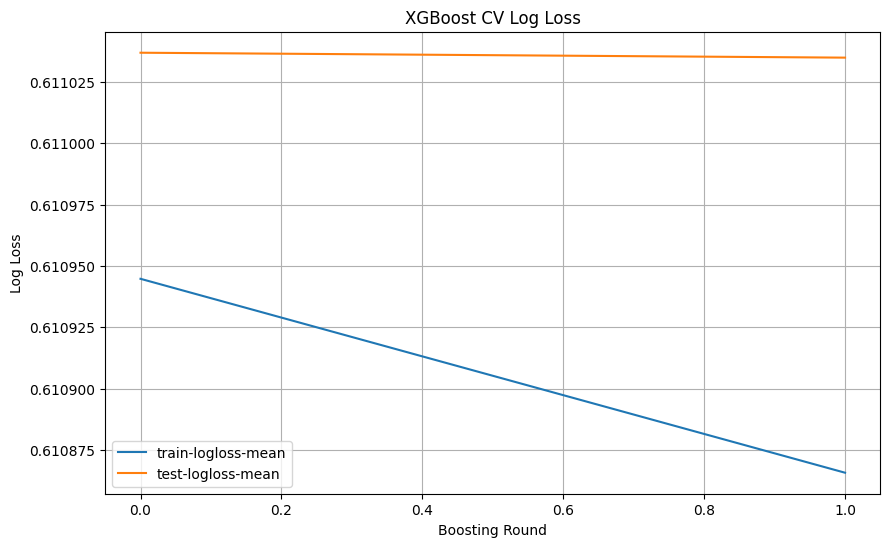

In [18]:
import xgboost as xgb
import pandas as pd

# Select only numeric columns for XGBoost DMatrix
X_numeric = X_train_transformed.select_dtypes(include=['number'])

dtrain = xgb.DMatrix(X_numeric, label=y_train)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'seed': 42
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    nfold=5,
    stratified=True,
    early_stopping_rounds=20,
    metrics='logloss',
    seed=42,
    verbose_eval=False
)

print(cv_results.tail())

cv_results[['train-logloss-mean', 'test-logloss-mean']].plot(figsize=(10, 6))
plt.title("XGBoost CV Log Loss")
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()


Train log loss decreases: The model is getting better at fitting the training data, reducing its error.

Test log loss stable (not decreasing): The model is not improving on unseen data, indicating it is not generalizing better.

Plus, there is a gap between train and test errors grows: The model is likely memorizing training examples rather than learning general patterns.

*OPTIONS:*

We will focuse on XGBoost here, so, regularization and model tuning:

_L1 Regularization (alpha or reg_alpha)

_L2 Regularization (lambda or reg_lambda)

_Early Stopping (early_stopping_rounds)

_Minimum Child Weight (min_child_weight)
Sets the minimum sum of instance weights (hessian) needed in a child node. Higher values make the algorithm more conservative, avoiding splits that create small leaf nodes with few samples.

_Gamma (gamma)
Specifies the minimum loss reduction required to make a further partition on a leaf node. Higher gamma values result in fewer splits, producing simpler trees and reducing overfitting.

In [19]:
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate= 0.01,
    min_child_weight= 7,
    max_depth= 10,
    n_estimators= 100,
    colsample_bytree= 0.9, 
    reg_alpha= 10, 
    reg_lambda= 0.1,
    gamma= 0.1,
    subsample=0.6,
    verbose=2
)

print(model.get_params())


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 10, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False, 'verbose': 2}


In [20]:
def encode_categoricals(df):
	df = df.copy()
	for col in df.select_dtypes(include='object').columns:
		df[col] = df[col].astype('category').cat.codes
	return df

X_train_xgb = encode_categoricals(X_train_transformed)
X_test_xgb = encode_categoricals(X_test_transformed)

model.fit(X_train_xgb, y_train)
xgboost_predict = model.predict(X_test_xgb)
xgboost_predict_prob = model.predict_proba(X_test_xgb)[:, 1]

In [21]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_xgb, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

precision, recall, fscore, support = score(y_test, xgboost_predict)
print(f'The recall value for the baseline xgboost model is {recall[1]:.4f}')


Cross-Validation Accuracy: 0.6998 ± 0.0000
The recall value for the baseline xgboost model is 1.0000


In [35]:
from sklearn.model_selection import train_test_split

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

def feature_engineering(df, train_data):
    mood_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    adapt_map = {'Problem Focus': 1, 'Emotion Focus': 0}
    workload_map = {'Easy': 1, 'Possible': 2, 'Difficult': 3, 'Impossible': 4}
    stress_map = {'Low': 1, 'Medium': 2, 'High': 3}

    df = df.copy()
    if 'Mood_Score' in df.columns:
        df['Mood_Score_Enc'] = df['Mood_Score'].map(mood_map)
    if 'Adaptability' in df.columns:
        df['Adaptability_Enc'] = df['Adaptability'].map(adapt_map)
    if 'Workload Perception' in df.columns:
        df['Workload_Num'] = df['Workload Perception'].map(workload_map)
    if 'Stress_Level' in df.columns:
        df['Stress_Num'] = df['Stress_Level'].map(stress_map)

    orbit_threshold = train_data['Orbit_Distance_km'].quantile(0.95)
    if 'Orbit_Distance_km' in df.columns:
        df['High_Orbit'] = (df['Orbit_Distance_km'] > orbit_threshold).astype(int)

    sleep_threshold = train_data['Sleep_Quality'].quantile(0.25)
    if 'Sleep_Quality' in df.columns:
        df['Sleep_Deficit'] = (df['Sleep_Quality'] < sleep_threshold).astype(int)

    social_threshold = train_data['Sociability'].quantile(0.25)
    if 'Sociability' in df.columns:
        df['Social_Isolation'] = (df['Sociability'] < social_threshold).astype(int)

    if 'Happiness' in df.columns and 'Sleep_Quality' in df.columns:
        df['Happiness_x_Sleep'] = df['Happiness'] * df['Sleep_Quality']

    if 'Sociability' in df.columns and 'Communication_with_Earth_mins' in df.columns:
        df['Social_Comm_Sum'] = df['Sociability'] + df['Communication_with_Earth_mins']

    if 'Workload_Num' in df.columns and 'Stress_Num' in df.columns:
        df['Workload_Stress_Ratio'] = df['Workload_Num'] / (df['Stress_Num'].replace(0, np.nan))

    if 'Sleep_Quality' in df.columns and 'Workload_Num' in df.columns:
        df['Sleep_to_Work'] = df['Sleep_Quality'] / (df['Workload_Num'].replace(0, np.nan))

    for col in ['Workload_Stress_Ratio', 'Sleep_to_Work']:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    return df

X_val_fe = feature_engineering(X_val, train_data)
X_test_fe = feature_engineering(X_test_xgb, train_data)

X_train_sub_enc = encode_categoricals(X_train_sub)
X_val_enc = encode_categoricals(X_val_fe)
X_test_enc = encode_categoricals(X_test_fe)

model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.01,
    min_child_weight=7,
    max_depth=10,
    n_estimators=100,
    colsample_bytree=0.9,
    reg_alpha=10,
    reg_lambda=0.1,
    gamma=0.1,
    subsample=0.6,
    verbose=2
)


Retraining the model with eval_set just to be able to plot the learning curve

[0]	validation_0-logloss:0.61094	validation_1-logloss:0.61106
[1]	validation_0-logloss:0.61084	validation_1-logloss:0.61106
[2]	validation_0-logloss:0.61074	validation_1-logloss:0.61107
[3]	validation_0-logloss:0.61065	validation_1-logloss:0.61107
[4]	validation_0-logloss:0.61055	validation_1-logloss:0.61108
[5]	validation_0-logloss:0.61045	validation_1-logloss:0.61109
[6]	validation_0-logloss:0.61035	validation_1-logloss:0.61109
[7]	validation_0-logloss:0.61025	validation_1-logloss:0.61109
[8]	validation_0-logloss:0.61018	validation_1-logloss:0.61109
[9]	validation_0-logloss:0.61008	validation_1-logloss:0.61110
[10]	validation_0-logloss:0.60998	validation_1-logloss:0.61111
[11]	validation_0-logloss:0.60989	validation_1-logloss:0.61111
[12]	validation_0-logloss:0.60979	validation_1-logloss:0.61112
[13]	validation_0-logloss:0.60968	validation_1-logloss:0.61113
[14]	validation_0-logloss:0.60958	validation_1-logloss:0.61114
[15]	validation_0-logloss:0.60949	validation_1-logloss:0.61113
[1

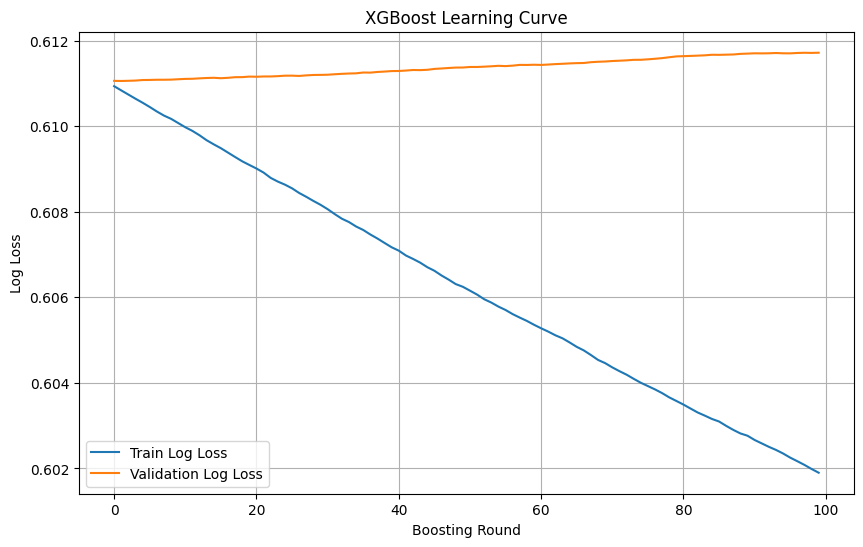

In [36]:
import matplotlib.pyplot as plt

model.fit(
	X_train_xgb, y_train,
	eval_set=[(X_train_xgb, y_train), (X_test_xgb, y_test)],
	verbose=True, 
)

results = model.evals_result()

train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Log Loss')
plt.plot(val_loss, label='Validation Log Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


Test of SHAP (SHapley Additive exPlanations) 


SHAP is a game theoretic approach to explain the output of any machine learning model. 

It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

Red = Indicating high values ; Blue = Low

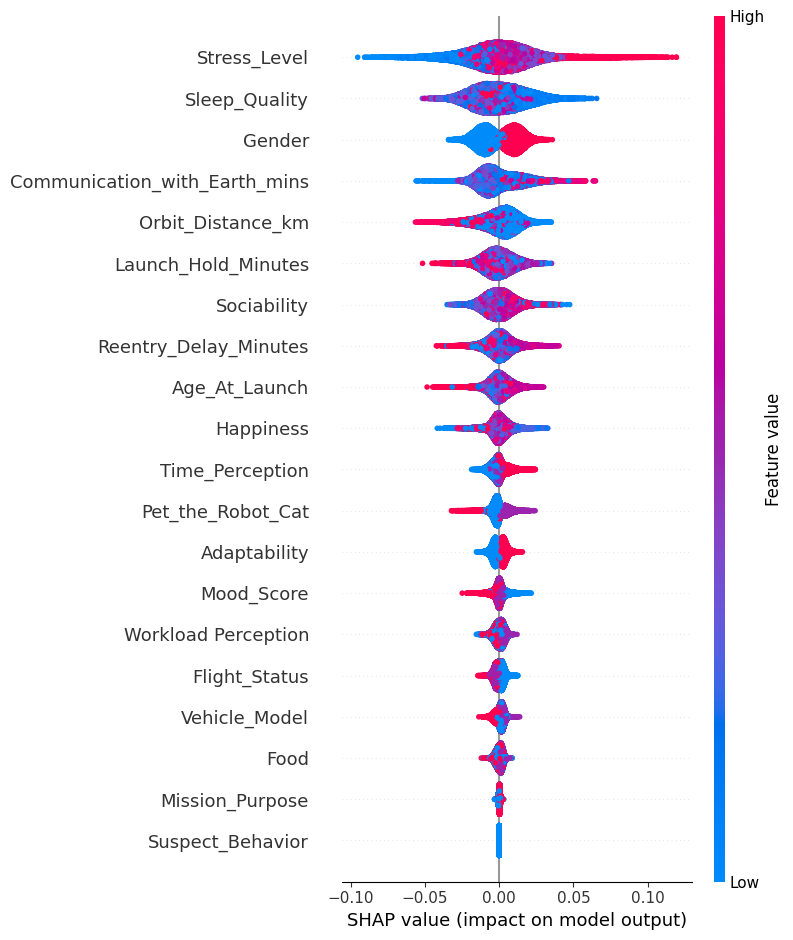

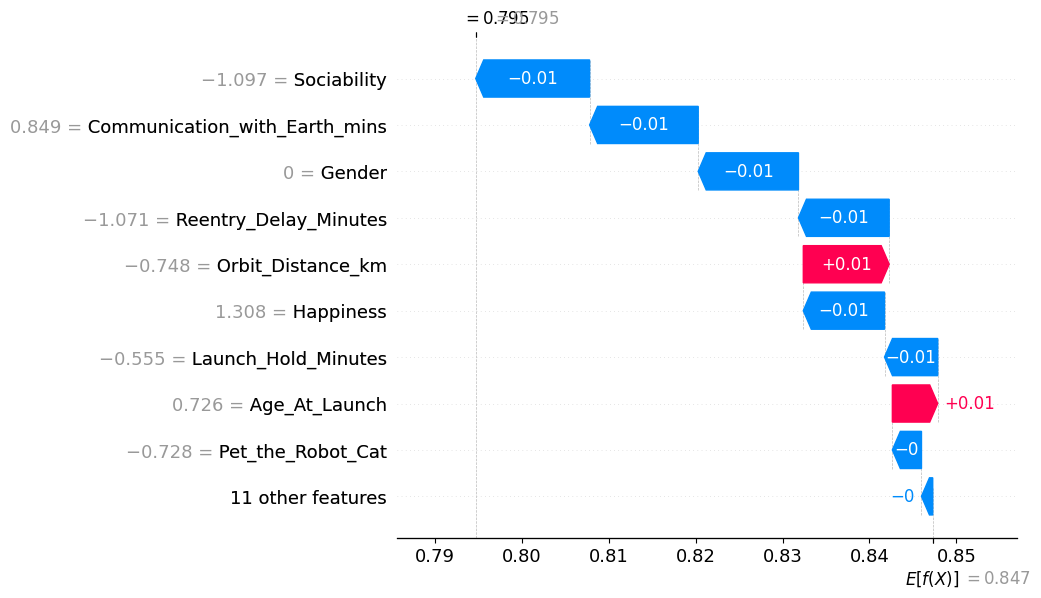

In [34]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_xgb)

shap.summary_plot(shap_values, X_train_xgb, feature_names=X_train_xgb.columns)

shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                      base_values=explainer.expected_value, 
                                      data=X_train_xgb.iloc[0], 
                                      feature_names=X_train_xgb.columns))

Grid Search for XGBoost

In [37]:
param_grid = { 

    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    
    "reg_alpha": [0, 0.5, 1, 5],
    
    "reg_lambda": [0, 0.5, 1, 5]
    }

scoring = ['recall']

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

Grit Search is more expensive in terms of execution time

Beacause: 
3 n_estimators × 3 max_depth × 3 learning_rate = 27 combinations

With 5-fold CV → 27 × 5 = 135 model trainings

Coffee time or... Early Stopping ? 

GridSearchCV does not support passing eval_set or early_stopping_rounds directly to the underlying XGBoost model’s fit() method.

Solution: Wrap the XGBoost model inside a custom class that passes eval_set and early_stopping_rounds during .fit()


In [38]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=model,  
    param_grid=param_grid,
    scoring='recall',  
    refit=True,
    n_jobs=-1,
    cv=kfold,
    verbose=0
)

grid_result = grid_search.fit(
    X_train_xgb, 
    y_train, 
    eval_set=[(X_train_xgb, y_train), (X_test_xgb, y_test)]
)

print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_score'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

[0]	validation_0-logloss:0.61085	validation_1-logloss:0.61107
[1]	validation_0-logloss:0.61080	validation_1-logloss:0.61106
[2]	validation_0-logloss:0.61070	validation_1-logloss:0.61106
[3]	validation_0-logloss:0.61058	validation_1-logloss:0.61108
[4]	validation_0-logloss:0.61047	validation_1-logloss:0.61108
[5]	validation_0-logloss:0.61032	validation_1-logloss:0.61109
[6]	validation_0-logloss:0.61021	validation_1-logloss:0.61109
[7]	validation_0-logloss:0.61013	validation_1-logloss:0.61109
[8]	validation_0-logloss:0.61007	validation_1-logloss:0.61108
[9]	validation_0-logloss:0.60993	validation_1-logloss:0.61111
[10]	validation_0-logloss:0.60980	validation_1-logloss:0.61112
[11]	validation_0-logloss:0.60968	validation_1-logloss:0.61113
[12]	validation_0-logloss:0.60959	validation_1-logloss:0.61114
[13]	validation_0-logloss:0.60945	validation_1-logloss:0.61115
[14]	validation_0-logloss:0.60938	validation_1-logloss:0.61115
[15]	validation_0-logloss:0.60933	validation_1-logloss:0.61115
[1

Creation of a Wrapper

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
from sklearn.model_selection import train_test_split

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, 
                 eval_set=None, early_stopping_rounds=10, **kwargs):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.eval_set = eval_set
        self.early_stopping_rounds = early_stopping_rounds
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = xgb.XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            use_label_encoder=False,
            eval_metric='logloss',
            **self.kwargs
        )
        fit_params = {}
        if self.eval_set is not None:
            fit_params['eval_set'] = self.eval_set
            fit_params['early_stopping_rounds'] = self.early_stopping_rounds
            fit_params['verbose'] = False
        
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


Check your XGBoost version
If it’s older than ~1.3.0, update it

XGBWrapper model

In [40]:
eval_set = [(X_test, y_test)]

model2 = XGBWrapper(eval_set=eval_set, early_stopping_rounds=20)


In [41]:
model2 = XGBWrapper()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    refit=True,
    n_jobs=-1,
    cv=kfold,
    verbose=0
)

grid_result = grid_search.fit(X_train_xgb, y_train)

print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score std deviation is', round(grid_result.cv_results_['std_test_score'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 1.0000
The best score std deviation is 0.0
The best hyperparameters are {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Random Search for XGBoost

In [42]:
param_grid = { 
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    "max_depth": range(3, 21, 3),
    "gamma": [i/10.0 for i in range(0, 5)],
    "colsample_bytree": [i/10.0 for i in range(3, 10)],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],           
    "min_child_weight": [1, 3, 5, 7],                  
    "reg_alpha": [1e-5, 0.01, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 0.01, 0.1, 1, 10, 100]
}

scoring = ['recall']

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


In [43]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=model,  
    param_distributions=param_grid,
    n_iter=48,
    scoring='recall',  
    refit=True,
    n_jobs=-1,
    cv=kfold,
    verbose=0
)

random_result = random_search.fit(X_train_xgb, y_train)

print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_score'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 1.0000
The best score standard deviation is 0.0
The best hyperparameters are {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 10, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.0001, 'gamma': 0.2, 'colsample_bytree': 0.5}


In [44]:
random_predict = random_search.predict(X_test_xgb)
random_predict_prob = random_search.predict_proba(X_test_xgb)[:,1]
precision, recall, fscore, support = score(y_test, random_predict)

print(f'The recall value for the xgboost random search is {recall[1]:.4f}')

The recall value for the xgboost random search is 1.0000


Bayesian Optimization For XGBoost with hyperopt

In [45]:
from hyperopt import hp

space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])

}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [46]:
from hyperopt import STATUS_OK

def objective(params):
    
    xgboost = XGBClassifier(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train_transformed, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='recall', 
                            n_jobs=-1).mean()
   
    loss = - score
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [47]:
model_hyp = XGBClassifier(
    random_state= 42,
    eval_metric= 'logloss',
    scale_pos_weight= 1,
    use_label_encoder= False,
    learning_rate= 1,
    subsample= 0.7,
    max_depth= 3,
    gamma= 0.1,
    colsample_bytree= 1,
    min_child_weight= 7,
    n_estimators= 300,
    reg_alpha= 100,
    reg_lambda= 1,
    booster='gbtree', 
    tree_method= 'hist', 
    callbacks=None,
    colsample_bylevel=None, 
    colsample_bynode=None, 
    device=None, 
    early_stopping_rounds=None,
    enable_categorical=False, 
    feature_types=None, 
    feature_weights=None, 
    grow_policy=None, 
    importance_type=None,
    interaction_constraints=None, 
    max_bin=None,
    max_cat_threshold=None, 
    max_cat_to_onehot=None,
    max_delta_step=None,
    max_leaves=None, 
    monotone_constraints=None,
    multi_strategy=None,
    num_parallel_tree=None,
)

print(model_hyp.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 100, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [48]:
X_train_hyp = encode_categoricals(X_train_transformed)
X_test_hyp = encode_categoricals(X_test_transformed)

model_hyp.fit(X_train_hyp, y_train)
xgboost_predict = model_hyp.predict(X_test_hyp)
xgboost_predict_prob = model_hyp.predict_proba(X_test_hyp)[:, 1]

In [49]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_hyp, X_train_hyp, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

precision, recall, fscore, support = score(y_test, xgboost_predict)
print(f'The recall value for the baseline xgboost model is {recall[1]:.4f}')

Cross-Validation Accuracy: 0.6998 ± 0.0000
The recall value for the baseline xgboost model is 1.0000


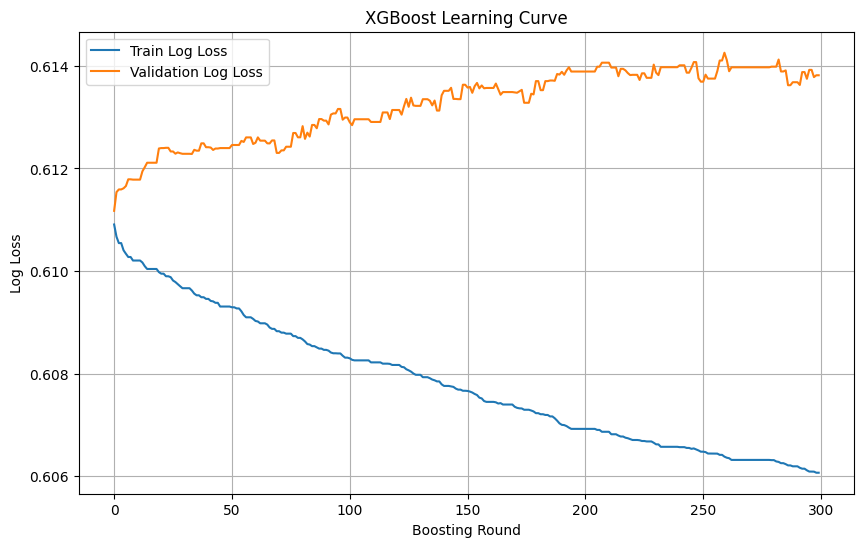

In [50]:
import matplotlib.pyplot as plt

X_train_hyp = encode_categoricals(X_train_transformed)
X_test_hyp = encode_categoricals(X_test_transformed)

model_hyp.fit(
	X_train_hyp, y_train,
	eval_set=[(X_train_hyp, y_train), (X_test_hyp, y_test)],
	verbose=False
)

results = model_hyp.evals_result()

train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Log Loss')
plt.plot(val_loss, label='Validation Log Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

## Define the hyperparameter search space for model_hyp

In [51]:
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK
import numpy as np


scale_pos_weight = float(np.sum(y_train == 0) / np.sum(y_train == 1))


space_values = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 10],
    'gamma': [0, 0.01, 0.1, 0.5, 1],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'n_estimators': [50, 100, 200, 300],
    'reg_alpha': [1e-5, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [1e-5, 0.01, 0.1, 1, 10, 100],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, scale_pos_weight],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'tree_method': ['auto', 'exact', 'hist'],
}

space = {
    'learning_rate': hp.choice('learning_rate', space_values['learning_rate']),
    'max_depth': hp.choice('max_depth', space_values['max_depth']),
    'gamma': hp.choice('gamma', space_values['gamma']),
    'colsample_bytree': hp.choice('colsample_bytree', space_values['colsample_bytree']),
    'min_child_weight': hp.choice('min_child_weight', space_values['min_child_weight']),
    'n_estimators': hp.choice('n_estimators', space_values['n_estimators']),
    'reg_alpha': hp.choice('reg_alpha', space_values['reg_alpha']),
    'reg_lambda': hp.choice('reg_lambda', space_values['reg_lambda']),
    'subsample': hp.choice('subsample', space_values['subsample']),
    'scale_pos_weight': hp.choice('scale_pos_weight', space_values['scale_pos_weight']),
    'booster': hp.choice('booster', space_values['booster']),
    'tree_method': hp.choice('tree_method', space_values['tree_method']),
}

def objective(params):
    model_hyp = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        verbosity=0,
        **params
    )
    score = cross_val_score(
        model_hyp, X_train_xgb, y_train,
        cv=kfold, scoring='recall', n_jobs=-1
    ).mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Best hyperparameters found by Hyperopt:")
print(best_hyperopt)

best_score = -min([t['result']['loss'] for t in trials.trials])
print("\nBest recall score (negative loss):", best_score)

readable_params = {key: space_values[key][best_hyperopt[key]] for key in best_hyperopt}

print("The best hyperparameters are:")
for k, v in readable_params.items():
    print(f"{k}: {v}")


100%|██████████| 30/30 [06:52<00:00, 13.76s/trial, best loss: -1.0]              
Best hyperparameters found by Hyperopt:
{'booster': np.int64(0), 'colsample_bytree': np.int64(4), 'gamma': np.int64(2), 'learning_rate': np.int64(4), 'max_depth': np.int64(0), 'min_child_weight': np.int64(3), 'n_estimators': np.int64(3), 'reg_alpha': np.int64(5), 'reg_lambda': np.int64(3), 'scale_pos_weight': np.int64(0), 'subsample': np.int64(1), 'tree_method': np.int64(2)}

Best recall score (negative loss): 1.0
The best hyperparameters are:
booster: gbtree
colsample_bytree: 1.0
gamma: 0.1
learning_rate: 1
max_depth: 3
min_child_weight: 7
n_estimators: 300
reg_alpha: 100
reg_lambda: 1
scale_pos_weight: 1
subsample: 0.7
tree_method: hist


In [52]:

X_train_bo = encode_categoricals(X_train_transformed)
X_test_bo = encode_categoricals(X_test_transformed)

xgboost_bo = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    **readable_params
)
xgboost_bo.fit(X_train_bo, y_train)

bayesian_opt_predict = xgboost_bo.predict(X_test_bo)
bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test_bo)[:, 1]

precision, recall, fscore, support = score(y_test, bayesian_opt_predict)

print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')

The recall value for the xgboost Bayesian optimization is 1.0000


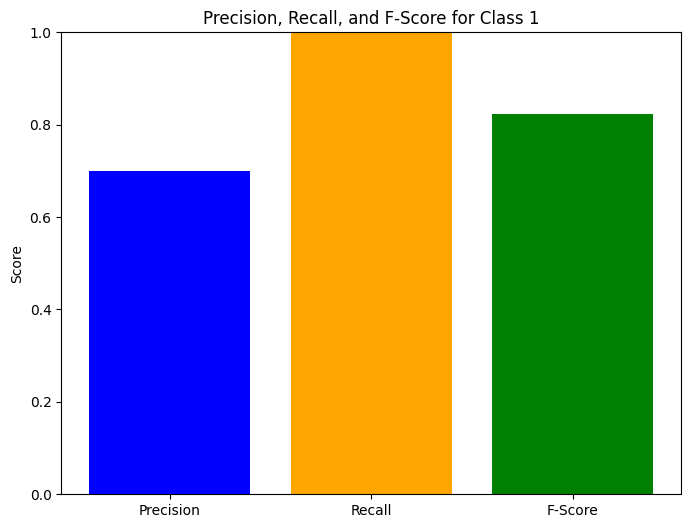

In [55]:
metrics = ['Precision', 'Recall', 'F-Score']
values = [precision[1], recall[1], fscore[1]]

plt.figure(figsize=(8,6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Precision, Recall, and F-Score for Class 1')
plt.ylabel('Score')
plt.show()


The model's performance on the training data continues to improve while the test performance plateaus or decreases, this is a strong sign of overfitting.

Good model: Both training and testing accuracy increase, and they stabilize together.

Overfitting: The training accuracy continues to rise, while the testing accuracy plateaus or starts to drop.

0.7 - 0.8: Acceptable discrimination

# Calculate ROC curve using predicted probabilities for the positive class

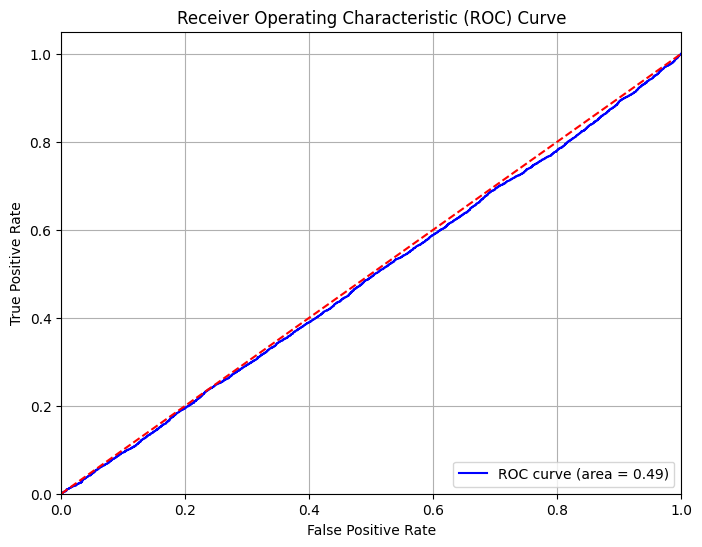

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = model.predict_proba(X_test_xgb)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Future Ensemble Method Models for Optimal Predictions Using Voting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True,
        'params': {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'liblinear']}
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True,
        'params': {'C': np.logspace(-3, 3, 20), 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1]}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=42, n_iter_no_change=20, validation_fraction=0.1),
        'use_scaled': False,
        'params': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True,
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=42),
        'use_scaled': False,
        'params': {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    },
    'xgb': {
        'model': XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,
            use_label_encoder=False,
            max_depth=int(18.0),
            learning_rate=0.1,
            gamma=0.035071764023253967,
            subsample=0.8,
            colsample_bytree=0.7604537475703804,
            min_child_weight=4.0,
            n_estimators=1100,
            reg_alpha=5.482471918941846,
            reg_lambda=4.54982507994119,
        ),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.8]}
    },

        'catboost': {
            'model': CatBoostClassifier(
                random_state=42,
                iterations=500,
                learning_rate=0.05,
                depth=8,
                verbose=0
            ),
            'use_scaled': False,
            'params': {}
        }
    }


voting_estimators = [
    #('logistic', models['logistic']['model']),
    ('rf', models['rf']['model']),
    ('xgb', models['xgb']['model']),
    ('catboost', models['catboost']['model']),
    #('gb', models['gb']['model']),
    #('dt', models['dt']['model']),
    ('svm', models['svm']['model']),
    #('knn', models['knn']['model'])
]

voting = VotingClassifier(estimators=voting_estimators, voting='soft')

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', voting)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Ensemble Voting (All Models) Accuracy:", accuracy_score(y_test, y_pred))